In [11]:
# Decision trees, ensemble methods, clustering
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

%matplotlib inline
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pydotplus

#loading data
train = pd.read_csv('train.csv')
train = train.dropna()
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


In [13]:
#Feature engineering (need to make categorical features into numbers)
def word2letter(X_word):
    X_letter = []
    for x in X_word:
        X_letter.append(x[0])
    return X_letter

train['Cabin_letter'] = word2letter(train['Cabin'])
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter  
1       0  PC 17599  71.2833   C85        C            C  
3       0    113803  53.1000  C123        S            C  
6       0     17463  51.8625   E46        S            E  
10      1   PP 9549  16.7000    G6        S            G  
11      0    

In [17]:
def text2number(X_word, words):
    numbers = range(len(words))
    
    X_number = X_word.copy()
    for n, w in zip(numbers, words):
        X_number[X_word == w] = n
    return X_number

embarked_words = list(set(train['Embarked']))
train['Embarked_number'] = text2number(train['Embarked'], embarked_words)

sex_words = list(set(train['Sex']))
train['Sex_number'] = text2number(train['Sex'], sex_words)

cabin_words = list(set(train['Cabin_letter']))
train['Cabin_number'] = text2number(train['Cabin_letter'], cabin_words)

print(train.head())

['Q', 'S', 'C']
    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter Embarked_number  \
1       0  PC 17599  71.2833   C85        C            C               2   
3       0    113803  53.1000  C123        S            C               1   
6       0     17463  51.8625   E46        S            E        

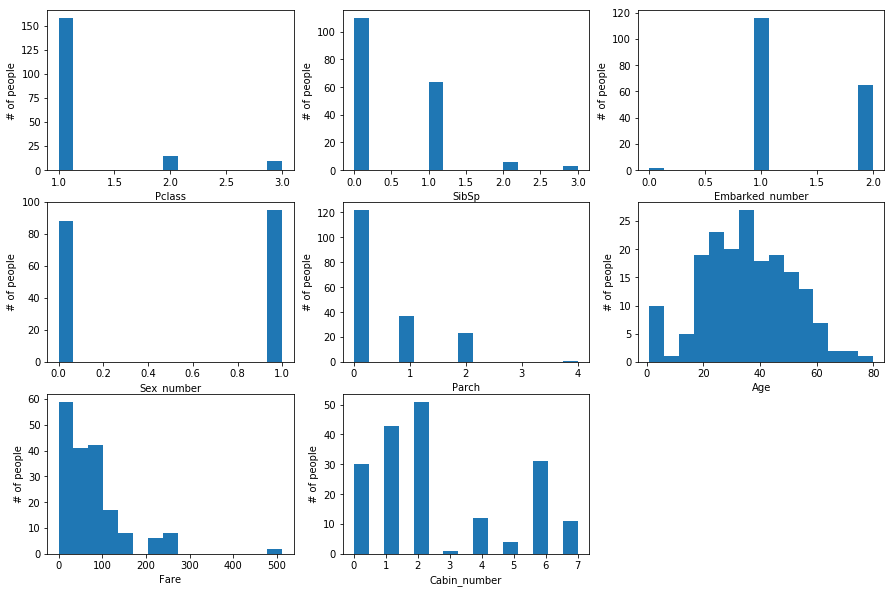

In [20]:
# plotting features
fig = plt.figure(figsize=(15,10))
for idx, f in enumerate(['Pclass', 'SibSp','Embarked_number','Sex_number', 'Parch','Age','Fare','Cabin_number']):
    ax = fig.add_subplot(3,3,idx+1)
    ax.hist(train[f],15)
    ax.set_xlabel(f)
    ax.set_ylabel('# of people')
plt.show()


In [21]:
##Making categorical features (coloumns of zeros (STAT 306))
X_num = train['Embarked_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Embarked_' + str(num)
    train[name] = X_cat

## Make categorical features for Cabin
X_num = train['Cabin_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Cabin_' + str(num)
    train[name] = X_cat

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_1,Embarked_2,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,1,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,1,0,0,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,1,0,1,0,0,0,0,0,0,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,...,1,0,0,0,0,0,0,1,0,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,...,1,0,0,0,1,0,0,0,0,0
